Vamos a meter el nivel de torneo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
from ranking_scores import puntos_ranking

In [2]:
def calculate_head_to_head(dataset):
    # Convertir la columna 'tourney_date' a formato de fecha
    dataset['tourney_date'] = pd.to_datetime(dataset['tourney_date'], format='%Y%m%d')

    # Ordenar el dataset por fecha
    dataset = dataset.sort_values('tourney_date')

    # Inicializar una nueva columna para el historial de enfrentamientos directos
    dataset['head_to_head'] = 0.5
    '''dataset['num_matches'] = 0'''
    # Iterar sobre las filas del dataset
    for index, row in dataset.iterrows():
        # Obtener los partidos anteriores entre los dos jugadores
        previous_matches = dataset[((dataset['winner_id'] == row['winner_id']) & (dataset['loser_id'] == row['loser_id']) | (dataset['winner_id'] == row['loser_id']) & (dataset['loser_id'] == row['winner_id'])) & (dataset['tourney_date'] < row['tourney_date'])]

        if not previous_matches.empty:
            # Calcular el porcentaje de veces que el 'winner_id' ha ganado
            wins = len(previous_matches[previous_matches['winner_id'] == row['winner_id']])
            total = len(previous_matches)
            dataset.at[index, 'head_to_head'] = wins / total
            '''# Calcular el número de partidos jugados
            dataset.at[index, 'num_matches'] = total'''

    return dataset

In [3]:
# Cargar los datos de los años
data_2021 = pd.read_csv('atp_matches_2021.csv')
data_2022 = pd.read_csv('atp_matches_2022.csv')
data_2023 = pd.read_csv('atp_matches_2023.csv')

# Agregar una columna 'source' a cada DataFrame
data_2021['source'] = 'atp_matches_2021.csv'
data_2022['source'] = 'atp_matches_2022.csv'
data_2023['source'] = 'atp_matches_2023.csv'

# Combinar los datos en un solo DataFrame
data_all = pd.concat([data_2021, data_2022, data_2023])

# Aplicar la función calculate_head_to_head
data_all = calculate_head_to_head(data_all)

# Filtrar los datos para obtener solo los partidos de 2023 del archivo 'atp_matches_2023.csv'
dataset = data_all[data_all['source'] == 'atp_matches_2023.csv']

In [4]:
tenistas = pd.concat([dataset['winner_id'], dataset['loser_id']])
tenistas = set(tenistas)
num_tenistas = len(tenistas)

In [5]:
dataset_r = pd.read_csv('atp_rankings_20s.csv')

### Realizamos el tratamiento de los NaN's antes de nada

In [6]:
# Encontramos el valor más común entre 'Grass', 'Hard', y 'Clay'
most_common = dataset[dataset['surface'].isin(['Grass', 'Hard', 'Clay'])]['surface'].mode()[0]

# Reemplazamos los valores que no son 'Grass', 'Hard', o 'Clay' (los NaN's) con el valor más común
dataset.loc[~dataset['surface'].isin(['Grass', 'Hard', 'Clay']), 'surface'] = most_common

In [7]:

print(set(dataset['tourney_level']))

{'M', 'D', 'A', 'G', 'F'}


In [8]:
pk = puntos_ranking(dataset, dataset_r, 2023)

c:\Users\Guille\OneDrive\Escritorio\Deepty Projects\tenis_project\ranking_scores.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['tourney_date'] = pd.to_datetime(dataset['tourney_date'], format='%Y%m%d')
c:\Users\Guille\OneDrive\Escritorio\Deepty Projects\tenis_project\ranking_scores.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['year_month'] = dataset['tourney_date'].dt.to_period('M')


In [9]:
dataset.loc[:, 'winner_rank_points'], dataset.loc[:, 'loser_rank_points'] = pk['winner_points'], pk['loser_points']

C:\Users\Guille\AppData\Local\Temp\ipykernel_25804\3391766934.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.loc[:, 'winner_rank_points'], dataset.loc[:, 'loser_rank_points'] = pk['winner_points'], pk['loser_points']


In [10]:
dataset.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,source,head_to_head,year_month
69,2023-2843,Adelaide 1,Hard,32,A,2023-01-02,279,207733,NaN,NaN,...,8.0,7.0,12.0,42.0,990,83.0,630,atp_matches_2023.csv,0.5,2023-01
70,2023-2843,Adelaide 1,Hard,32,A,2023-01-02,278,111575,8.0,NaN,...,9.0,8.0,12.0,20.0,1990,57.0,813,atp_matches_2023.csv,0.5,2023-01
71,2023-2843,Adelaide 1,Hard,32,A,2023-01-02,277,206173,6.0,NaN,...,8.0,1.0,4.0,15.0,2410,582.0,52,atp_matches_2023.csv,1.0,2023-01
72,2023-2843,Adelaide 1,Hard,32,A,2023-01-02,276,106423,NaN,WC,...,12.0,5.0,6.0,93.0,592,34.0,1163,atp_matches_2023.csv,0.5,2023-01
76,2023-2843,Adelaide 1,Hard,32,A,2023-01-02,272,111456,NaN,NaN,...,5.0,0.0,2.0,63.0,775,67.0,741,atp_matches_2023.csv,0.5,2023-01


In [11]:
'''Indice 7: ganador del partido.
Indice 15: perdedor del partido.
Indice -1: puntos en el ranking del jugador ganador
Indice -3: puntos en el ranking del jugador perdedor
Indice 2: tipo de campo del partido (grass, hard o clay)'''
'''X = dataset.iloc[:, [7, 15, -1, -3, 2]].values
y = dataset.iloc[:, 7].values'''

'X = dataset.iloc[:, [7, 15, -1, -3, 2]].values\ny = dataset.iloc[:, 7].values'

In [12]:
columnas_X = ['winner_id', 'loser_id', 'winner_rank_points', 'loser_rank_points', 'head_to_head', 'tourney_level', 'surface']
columna_y = 'winner_id'
X = dataset[columnas_X].values
y = dataset[columna_y].values


In [13]:
X[:, 0] = X[:, 0].astype(str)
X[:, 1] = X[:, 1].astype(str)
y = y.astype(str)

In [14]:
# Crear el codificador
encoder = OneHotEncoder(sparse_output=False)

# Ajustar el codificador con los datos de ambos jugadores y 'y'
encoder.fit(X[:, [0, 1]].reshape(-1, 1))

# Transformar las columnas de los jugadores
player1_onehot = encoder.transform(X[:, 0].reshape(-1, 1))
player2_onehot = encoder.transform(X[:, 1].reshape(-1, 1))

# Transformar el vector objetivo 'y' con el mismo codificador 'X'
y = encoder.transform(y.reshape(-1, 1))

# Concatenar las columnas one-hot con el resto de tus datos
X = np.concatenate([player1_onehot, player2_onehot, X[:, 2:]], axis=1)


In [15]:
# Matriz de booleanos aleatorios del mismo tamaño que tus datos
swap = np.random.rand(len(X)) > 0.5

# Intercambiamos las posiciones de los jugadores en 'X' donde 'swap' es True
X[swap, :num_tenistas], X[swap, num_tenistas:num_tenistas*2] = X[swap, num_tenistas:num_tenistas*2], X[swap, :num_tenistas].copy()

# Intercambiamos las posiciones de los puntos en el ranking donde 'swap' es True
X[swap, num_tenistas*2], X[swap, num_tenistas*2+1] = X[swap, num_tenistas*2+1], X[swap, num_tenistas*2].copy()

mask = (swap) & (X[:, -2] != -1)
X[mask, -3] = 1 - X[mask, -3]

In [16]:
from sklearn.preprocessing import StandardScaler

# Crear el escalador
scaler = StandardScaler()

X[:, [-5, -4]] = scaler.fit_transform(X[:, [-5, -4]])

In [17]:
# Esto es para el tipo de campo
# Crear el codificador
encoder2 = OneHotEncoder(sparse_output=False)

# Ajustar y transformar la columna del tipo de campo
field_type_onehot = encoder2.fit_transform(X[:, num_tenistas*2+4].reshape(-1, 1))

# Concatenar la columna one-hot con el resto de los datos
X = np.concatenate([X[:, :num_tenistas*2+4], field_type_onehot], axis=1)

In [18]:
# Esto es para el nivel del torneo
# Crear el codificador
encoder3 = OneHotEncoder(sparse_output=False)

# Ajustar y transformar la columna del tipo de campo
tourney_level_onehot = encoder2.fit_transform(X[:, num_tenistas*2+3].reshape(-1, 1))

# Concatenar la columna one-hot con el resto de los datos
X = np.concatenate([X[:, :num_tenistas*2+3], tourney_level_onehot, X[:, num_tenistas*2+4:]], axis=1)

In [19]:
# Primero, obtenemos las 440 primeras columnas de X
M = X[:, :440]

# Luego, agregamos la columna 880
M = np.hstack((M, X[:, 880].reshape(-1, 1)))

# Luego, agregamos las columnas entre las 440 y la 880
M = np.hstack((M, X[:, 440:880]))

# Luego, agregamos la columna 882
M = np.hstack((M, X[:, 881].reshape(-1, 1)))

# Finalmente, agregamos las columnas del final
M = np.hstack((M, X[:, 882:]))

In [20]:
X = M

In [21]:
# Luego, dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [22]:
X_train = X_train.astype('float64')
y_train = y_train.astype('float64')

In [23]:
muestras = [[0 for _ in range(20)] for _ in range(30)]
for i in range(30):  # i variará de 0 a 29
    for j in range(20):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        X_train = X_train.astype('float64')
        y_train = y_train.astype('float64')
        # Definimos el modelo
        model = Sequential()

        # Añadir la capa de entrada y la primera capa oculta
        model.add(Dense(units=128, activation='relu', input_dim=X_train.shape[1]))

        # Añadir la capa de salida
        model.add(Dense(units=y.shape[1], activation='softmax'))

        # Compilar el modelo
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Entrenar el modelo
        model.fit(X_train, y_train, epochs=i+10, batch_size=32)  # Las épocas variarán de 10 a 40

        X_test = X_test.astype('float64')
        y_test = y_test.astype('float64')

        # Hacemos la predicción
        prediccion_test = model.predict(X_test)

        # Obtenemos los índices donde hay un 1 en las primeras 440 columnas y en las siguientes 440 columnas
        indices_1 = np.where(X_test[:, :num_tenistas] == 1)[1]
        indices_2 = np.where(X_test[:, num_tenistas:num_tenistas*2] == 1)[1]

        # Obtenemos las predicciones para los índices obtenidos
        predicciones_1 = prediccion_test[np.arange(len(prediccion_test)), indices_1]
        predicciones_2 = prediccion_test[np.arange(len(prediccion_test)), indices_2]

        # Encontramos el índice del máximo para cada fila
        max_indices = np.where(predicciones_1 > predicciones_2, indices_1, indices_2)

        # Convertimos max_indices en un array 2D
        max_indices_2D = np.eye(encoder.categories_[0].shape[0])[max_indices]

        # Usamos el codificador para transformar los índices a sus etiquetas originales
        etiquetas_predichas = encoder.inverse_transform(max_indices_2D)
        etiqueta_y_test = encoder.inverse_transform(y_test)
        
        # Veamos cuántos partidos ha acertado para el test
        aciertos = sum(etiquetas_predichas == etiqueta_y_test)
        precision = aciertos / len(etiquetas_predichas)*100
        muestras[i][j] = precision



Epoch 1/10


75/75 [==============================] - 1s 2ms/step - loss: 5.6948 - accuracy: 0.0398
Epoch 2/10
75/75 [==============================] - 0s 2ms/step - loss: 4.5568 - accuracy: 0.1214
Epoch 3/10
75/75 [==============================] - 0s 2ms/step - loss: 4.0956 - accuracy: 0.3120
Epoch 4/10
75/75 [==============================] - 0s 2ms/step - loss: 3.6824 - accuracy: 0.4661
Epoch 5/10
75/75 [==============================] - 0s 2ms/step - loss: 3.2422 - accuracy: 0.5352
Epoch 6/10
75/75 [==============================] - 0s 2ms/step - loss: 2.7917 - accuracy: 0.6093
Epoch 7/10
75/75 [==============================] - 0s 2ms/step - loss: 2.3680 - accuracy: 0.6528
Epoch 8/10
75/75 [==============================] - 0s 2ms/step - loss: 1.9852 - accuracy: 0.6893
Epoch 9/10
75/75 [==============================] - 0s 2ms/step - loss: 1.6571 - accuracy: 0.7240
Epoch 10/10
19/19 [==============================] - 0s 1ms/step
Epoch 1/10
75/75 [==============================]

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (598,) (597,) 

In [ ]:
muestras_red = []
for i in range(len(muestras)):
    muestras_red.append(muestras[i])

In [ ]:
medias = [np.mean(lista) for lista in muestras_red]

Text(0, 0.5, 'Precisión del test')

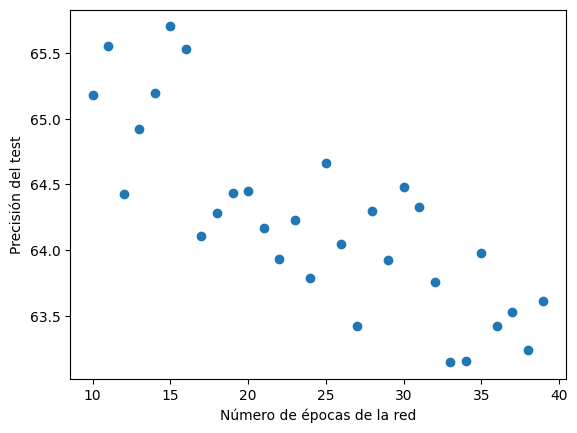

In [ ]:
plt.scatter(range(10, 40), medias)
plt.xlabel('Número de épocas de la red')
plt.ylabel('Precisión del test')

In [ ]:
constante = 1
W = np.full((X_train.shape[1], 128), constante)  
# Definimos el modelo
model = Sequential()

# Añadir la capa de entrada y la primera capa oculta
model.add(Dense(units=128, activation='relu', input_dim=X_train.shape[1]))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# Añadir la segunda capa oculta
# model.add(Dense(units=32, activation='tanh'))

# Añadir la capa de salida
model.add(Dense(units=y.shape[1], activation='softmax'))

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=15, batch_size=32)

Epoch 1/15
75/75 [==============================] - 1s 3ms/step - loss: 5.6995 - accuracy: 0.0465
Epoch 2/15
75/75 [==============================] - 0s 2ms/step - loss: 4.5692 - accuracy: 0.1080
Epoch 3/15
75/75 [==============================] - 0s 2ms/step - loss: 4.0984 - accuracy: 0.3229
Epoch 4/15
75/75 [==============================] - 0s 2ms/step - loss: 3.6798 - accuracy: 0.4615
Epoch 5/15
75/75 [==============================] - 0s 4ms/step - loss: 3.2379 - accuracy: 0.5704
Epoch 6/15
75/75 [==============================] - 0s 3ms/step - loss: 2.7916 - accuracy: 0.6164
Epoch 7/15
75/75 [==============================] - 0s 2ms/step - loss: 2.3685 - accuracy: 0.6608
Epoch 8/15
75/75 [==============================] - 0s 2ms/step - loss: 1.9868 - accuracy: 0.7006
Epoch 9/15
75/75 [==============================] - 0s 2ms/step - loss: 1.6566 - accuracy: 0.7332
Epoch 10/15
75/75 [==============================] - 0s 2ms/step - loss: 1.3827 - accuracy: 0.7500
Epoch 11/15
75/75 [

In [ ]:
X_test = X_test.astype('float64')
y_test = y_test.astype('float64')

In [ ]:
# Hacemos la predicción
prediccion_test = model.predict(X_test)

# Obtenemos los índices donde hay un 1 en las primeras 440 columnas y en las siguientes 440 columnas
indices_1 = np.where(X_test[:, :440] == 1)[1]
indices_2 = np.where(X_test[:, 441:881] == 1)[1]

# Obtenemos las predicciones para los índices obtenidos
predicciones_1 = prediccion_test[np.arange(len(prediccion_test)), indices_1]
predicciones_2 = prediccion_test[np.arange(len(prediccion_test)), indices_2]

# Encontramos el índice del máximo para cada fila
max_indices = np.where(predicciones_1 > predicciones_2, indices_1, indices_2)

# Convertimos max_indices en un array 2D
max_indices_2D = np.eye(encoder.categories_[0].shape[0])[max_indices]

# Usamos el codificador para transformar los índices a sus etiquetas originales
etiquetas_predichas = encoder.inverse_transform(max_indices_2D)

print(etiquetas_predichas)

19/19 [==============================] - 0s 1ms/step
[['210097']
 ['106421']
 ['106421']
 ['200221']
 ['111575']
 ['105870']
 ['128034']
 ['104925']
 ['210097']
 ['106043']
 ['207925']
 ['105747']
 ['134868']
 ['105430']
 ['144895']
 ['126094']
 ['122669']
 ['105554']
 ['126203']
 ['136440']
 ['126203']
 ['111575']
 ['128034']
 ['106186']
 ['210097']
 ['106148']
 ['208029']
 ['126127']
 ['105173']
 ['126203']
 ['126203']
 ['111575']
 ['126239']
 ['105583']
 ['106210']
 ['126846']
 ['104545']
 ['105173']
 ['202103']
 ['134770']
 ['106421']
 ['104925']
 ['200175']
 ['200325']
 ['144719']
 ['208103']
 ['105554']
 ['207733']
 ['111513']
 ['111797']
 ['208286']
 ['124116']
 ['208029']
 ['144895']
 ['126203']
 ['106186']
 ['111456']
 ['122330']
 ['106415']
 ['144707']
 ['106432']
 ['200325']
 ['126203']
 ['105777']
 ['100644']
 ['206173']
 ['111456']
 ['100644']
 ['144719']
 ['200270']
 ['202103']
 ['208029']
 ['126774']
 ['100644']
 ['106186']
 ['126239']
 ['106148']
 ['104545']
 ['111456']

In [ ]:
# Usamos el codificador para transformar las etiquetas codificadas a sus etiquetas originales
etiqueta_y_test = encoder.inverse_transform(y_test)

print(etiqueta_y_test)

[['210097']
 ['207989']
 ['106421']
 ['200221']
 ['111575']
 ['105870']
 ['128034']
 ['104925']
 ['106218']
 ['106043']
 ['208134']
 ['105747']
 ['134868']
 ['105430']
 ['106281']
 ['122330']
 ['105870']
 ['105554']
 ['126203']
 ['106214']
 ['126203']
 ['111575']
 ['128034']
 ['106186']
 ['210097']
 ['106148']
 ['208029']
 ['126127']
 ['105173']
 ['126203']
 ['126203']
 ['111575']
 ['200384']
 ['105583']
 ['106210']
 ['106121']
 ['207182']
 ['105173']
 ['202103']
 ['106121']
 ['106421']
 ['104925']
 ['200175']
 ['200325']
 ['206499']
 ['206681']
 ['105554']
 ['126952']
 ['111513']
 ['111797']
 ['208286']
 ['124116']
 ['208029']
 ['206681']
 ['105173']
 ['106329']
 ['111456']
 ['106233']
 ['144869']
 ['144707']
 ['106432']
 ['206173']
 ['126203']
 ['105777']
 ['100644']
 ['206173']
 ['111456']
 ['100644']
 ['210097']
 ['105641']
 ['202103']
 ['208029']
 ['126774']
 ['100644']
 ['206909']
 ['126239']
 ['106148']
 ['104545']
 ['111456']
 ['104925']
 ['209950']
 ['105554']
 ['207830']
 ['2

In [ ]:
# Veamos cuántos partidos ha acertado para el test
aciertos = sum(etiquetas_predichas == etiqueta_y_test)
precision = aciertos / len(etiquetas_predichas)*100
print(f"Precisión del test: {np.round(precision[0], 2)}%")

Precisión del test: 64.88%
